In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


/home/feodor/Jupyter/jupyter-env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import itertools

import numpy as np
import pandas as pd
import gudhi as gh
import networkx as nx

from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

from src.depth import DepthPoset
from src.drow import plot_filtred_complex2d, plot_simplex

from tqdm import tqdm

# Draw the Simplicial Complex

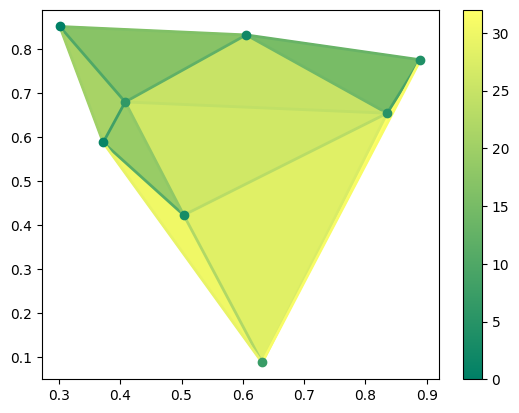

In [3]:
n, dim = 8, 2
points = np.random.random([n, dim])

stree = gh.AlphaComplex(points).create_simplex_tree()
simplices = [simplex for simplex, value in stree.get_filtration()]
filtration_values = np.asarray([value for simplex, value in stree.get_filtration()])
new_filtration_values = np.argsort(filtration_values)
for simplex, value in zip(simplices, new_filtration_values):
    stree.assign_filtration(simplex, value)

sm = plot_filtred_complex2d(stree, points, cmap='summer')
plt.colorbar(sm, ax=plt.gca())

# Define and iterate Transpositions

In [4]:
def order_is_possible(order):
    # returns False if there are bigger simplices before the smallest
    for i0 in range(len(order)):
        for i1 in range(i0 + 1, len(order)):
            s0 = np.sort(order[i0])
            s1 = np.sort(order[i1])
            intersection = np.intersect1d(s0, s1)
            if list(s1) == list(intersection):
                return False
    return True

In [5]:
def iterate_possible_transpositions(order, neighbours=True):
    # 
    if neighbours:
        generator = np.transpose([np.arange(len(order) - 1), np.arange(len(order) - 1) + 1])
    else:
        generator = itertools.combinations(range(len(order)), 2)
    for i0, i1 in generator:
        new_order = order.copy()
        new_order[i0], new_order[i1] = new_order[i1], new_order[i0]
        if order_is_possible(new_order):
            yield i0, i1

In [6]:
def get_random_transposition(order, neighbours=True):
    #
    if neighbours:
        tr0 = np.random.randint(len(order) - 1)
        tr1 = tr0 + 1
    else:
        tr0, tr1 = np.random.choice(np.arange(len(order)), 2, replace=False)
    new_order = order[:]
    new_order[tr0], new_order[tr1] = new_order[tr1], new_order[tr0]
    if order_is_possible(new_order):
        return tr0, tr1
    else:
        return get_random_transposition(order, neighbours=neighbours)

In [7]:
order = list(np.array(simplices, dtype=object)[np.argsort(filtration_values)])
print('; '.join([f'{i}: {s}' for i, s in enumerate(order)]))

0: [0]; 1: [1]; 2: [2]; 3: [3]; 4: [4]; 5: [5]; 6: [6]; 7: [7]; 8: [1, 6]; 9: [4, 5]; 10: [0, 6]; 11: [1, 3]; 12: [2, 6]; 13: [2, 4]; 14: [2, 5]; 15: [2, 4, 5]; 16: [0, 2]; 17: [0, 2, 6]; 18: [3, 6]; 19: [1, 3, 6]; 20: [0, 1]; 21: [0, 1, 6]; 22: [3, 7]; 23: [3, 5]; 24: [5, 6]; 25: [2, 5, 6]; 26: [3, 5, 6]; 27: [5, 7]; 28: [3, 5, 7]; 29: [1, 7]; 30: [1, 3, 7]; 31: [4, 7]; 32: [4, 5, 7]


In [8]:
tr0, tr1 = get_random_transposition(order)
tr0, tr1

(13, 14)

# Measure the difference Between Depth Posets

In [9]:
tr0, tr1 = get_random_transposition(order, neighbours=True)
print(f'Transposition: {tr0, tr1} - <{order[tr0]}, {order[tr1]}>')

order0 = order[:]
order1 = order[:]
order1[tr0], order1[tr1] = order1[tr1], order1[tr0]

if len(order0) <= 32:
    for i, (s0, s1) in enumerate(zip(order0, order1)):
        if i in [tr0, tr1]:
            print(f'<{i}>', s0, s1)
        else:
            print(f' {i} ', s0, s1)

Transposition: (23, 24) - <[3, 5], [5, 6]>


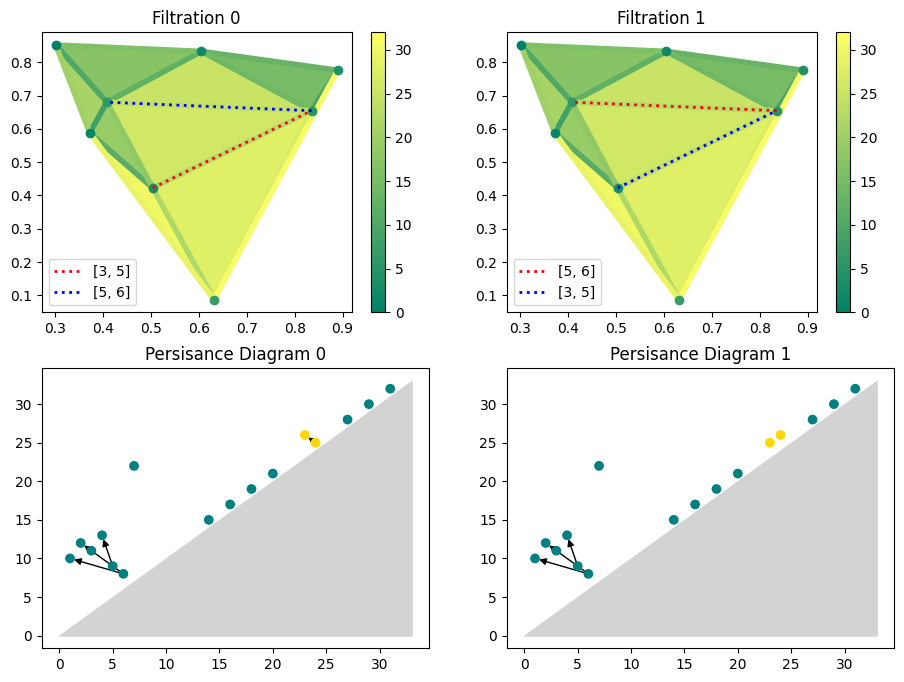

In [10]:
stree0 = gh.SimplexTree()
stree1 = gh.SimplexTree()

for filtration_value, (s0, s1) in enumerate(zip(order0, order1)):
    stree0.insert(s0, filtration=filtration_value)
    stree1.insert(s1, filtration=filtration_value)

dp0 = DepthPoset.from_simplex_tree(stree0)
dp1 = DepthPoset.from_simplex_tree(stree1)

fig, axs = plt.subplots(2, 2, figsize=(11, 8))

cmap = plt.get_cmap('summer')
for i, (stree, order, dp) in enumerate([(stree0, order0, dp0), (stree1, order1, dp1)]):
    axs[0, i].set_title(f'Filtration {i}')
    sm = plot_filtred_complex2d(stree, points, ax=axs[0, i], cmap=cmap, linewidth=4)
    plt.colorbar(sm, ax=axs[0, i])

    # drowing transposed simplices
    s0, s1 = order[tr0], order[tr1]
    plot_simplex(s0, points, ax=axs[0, i], color='red', marker='x', linestyle=':', hatch='+', label=str(s0), zorder=4)
    plot_simplex(s1, points, ax=axs[0, i], color='blue', marker='x', linestyle=':', hatch='+', label=str(s1), zorder=4)
    axs[0, i].legend()

    axs[1, i].set_title(f'Persisance Diagram {i}')
    node_color = ['gold' if tuple(s0) in node.source or tuple(s1) in node.source else 'teal' for node in dp.nodes]
    nx.draw_networkx(dp.get_transitive_reduction(), pos=dp.persistant_layout(), ax=axs[1, i], 
                     node_color=node_color, node_size=36, 
                     labels=dp.get_labels(), 
                     with_labels=False, hide_ticks=False)
    axs[1, i].fill_between([0, len(order)], [0, len(order)], [0, 0], color='lightgrey')
    axs[1, i].set_xlim(*(len(order)*np.array([-0.05, 1.05])))
    axs[1, i].set_ylim(*(len(order)*np.array([-0.05, 1.05])))


In [11]:
def get_nodes_intersection(dp0, dp1):
    """
    Returns the array of nodes, which are in both posets.
    """
    nodes = []
    for node in dp0.nodes + dp1.nodes:
        if node in dp0.nodes and node in dp1.nodes and not node in nodes:
            nodes.append(node)
    return nodes

def get_nodes_difference(dp0, dp1):
    """
    Returns the array of nodes, which are included in the 1st poset, but not the 2nd.
    """
    nodes = []
    for node in dp0.nodes:
        if not node in dp1.nodes:
            nodes.append(node)
    return nodes

In [12]:
len(get_nodes_intersection(dp0, dp1)), len(get_nodes_difference(dp0, dp1)), len(get_nodes_difference(dp1, dp0))

(16, 0, 0)

In [13]:
def get_edges_intersection(dp0, dp1):
    """
    Returns the array of edges, which are in both posets.
    """
    edges = []
    for edge in dp0.edges + dp1.edges:
        if edge in dp0.edges and edge in dp1.edges and not edge in edges:
            edges.append(edge)
    return edges

def get_edges_difference(dp0, dp1):
    """
    Returns the array of edges, which are included in the first poset, but not the second.
    """
    edges = []
    for edge in dp0.edges:
        if not edge in dp1.edges:
            edges.append(edge)
    return edges

In [14]:
len(get_edges_intersection(dp0, dp1)), len(get_edges_difference(dp0, dp1)), len(get_edges_difference(dp1, dp0))

(3, 1, 0)

In [15]:
def count_nodes_intersection(dp0, dp1):
    """
    The number of nodes in the posets intersection 
    """
    return len(get_nodes_intersection(dp0, dp1))

def count_nodes_left_difference(dp0, dp1):
    """
    The number of nodes in the 1st poset not included in the 2nd 
    """
    return len(get_nodes_difference(dp0, dp1))
    
def count_nodes_right_difference(dp0, dp1):
    """
    The number of nodes in the 2nd poset not included in the 1st 
    """
    return len(get_nodes_difference(dp1, dp0))

def count_edges_intersection(dp0, dp1):
    """
    The number of edges in the posets intersection 
    """
    return len(get_edges_intersection(dp0, dp1))

def count_edges_left_difference(dp0, dp1):
    """
    The number of edges in the 1st poset not included in the 2nd 
    """
    return len(get_edges_difference(dp0, dp1))
    
def count_edges_right_difference(dp0, dp1):
    """
    The number of edges in the 2nd poset not included in the 1st 
    """
    return len(get_edges_difference(dp1, dp0))

# Calculate Scores for Transpositions

In [16]:
scores = [count_nodes_intersection, count_nodes_left_difference, count_nodes_right_difference, 
          count_edges_intersection, count_edges_left_difference, count_edges_right_difference, 
         ]

In [17]:
order0 = order
stree0 = gh.SimplexTree()
for filtration_value, simplex in enumerate(order0):
    stree0.insert(simplex, filtration=filtration_value)

dp0 = DepthPoset.from_simplex_tree(stree0)

df = []

transpositions_generator = list(iterate_possible_transpositions(order0, neighbours=True))

for tr0, tr1 in tqdm(transpositions_generator, total=len(list(transpositions_generator))):
    stree1 = stree0.copy()
    stree1.insert(order0[tr0], stree0.filtration(order0[tr1]))
    stree1.insert(order0[tr1], stree0.filtration(order0[tr0]))

    dp1 = DepthPoset.from_simplex_tree(stree1)

    row = {'Transposition': (tr0, tr1)}
    for score in scores:
        row.update({score.__name__: score(dp0, dp1)})
    df.append(row)

df = pd.DataFrame(df)
df.head()

100%|██████████████████████████████████████████| 25/25 [00:00<00:00, 285.49it/s]


,Transposition,count_nodes_intersection,count_nodes_left_difference,count_nodes_right_difference,count_edges_intersection,count_edges_left_difference,count_edges_right_difference
0,"(0, 1)",16,0,0,3,0,0
1,"(1, 2)",16,0,0,3,0,0
2,"(2, 3)",16,0,0,3,0,0
3,"(3, 4)",16,0,0,3,0,0
4,"(4, 5)",16,0,0,3,0,0


In [18]:
df[[score.__name__ for score in scores]].median()

count_nodes_intersection        16.0
count_nodes_left_difference      0.0
count_nodes_right_difference     0.0
count_edges_intersection         3.0
count_edges_left_difference      0.0
count_edges_right_difference     0.0
dtype: float64

In [19]:
df.loc[(df[[score.__name__ for score in scores]].median() != df[[score.__name__ for score in scores]]).any(axis=1)]

,Transposition,count_nodes_intersection,count_nodes_left_difference,count_nodes_right_difference,count_edges_intersection,count_edges_left_difference,count_edges_right_difference
10,"(10, 11)",16,0,0,3,0,1
12,"(12, 13)",16,0,0,3,0,1
19,"(23, 24)",16,0,0,3,0,1
